# Data Loading

In [0]:
%matplotlib inline

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer



# using the SQLite Table to read data.
con = sqlite3.connect('dataset/database.sqlite') 



#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3
""", con) 




# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

# Data Cleaning

In [0]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)

In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [5]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [7]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


positive    307061
negative     57110
Name: Score, dtype: int64

# Text Preprocessing

In [8]:
# find sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;    


6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [0]:
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [0]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [0]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 

# Time Based Sorting

In [0]:
final=final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [0]:
scores = final['Score']

# Split the Data Set into train and test

In [14]:
# ============================== loading libraries ===========================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
from sklearn.naive_bayes import BernoulliNB
import warnings
# =============================================================================================

#supress warnings
warnings.filterwarnings("ignore")

# split the data set into train and test
X_1, X_test, y_1, y_test = cross_validation.train_test_split(final['Text'].values, scores, test_size=0.3, random_state=0)

y_test = y_test.values
y_1 = y_1.values

#sampling data
train_indices = np.random.choice(len(X_1),20000,replace=False)
test_indices = np.random.choice(len(X_test),5000,replace=False)
X_1 = X_1[train_indices]
X_test = X_test[test_indices]
y_1 = y_1[train_indices]
y_test = y_test[test_indices]

# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(X_1, y_1, test_size=0.3)


/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Converting Text to AvgW2Vec

In [0]:
# Train your own Word2Vec model using X_tr
import gensim
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
i=0
list_of_sent_X_tr=[]
for sent in X_tr:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_X_tr.append(filtered_sentence)

In [0]:
w2v_model=gensim.models.Word2Vec(list_of_sent_X_tr,min_count=1,size=50, workers=4) 

In [0]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_X_tr = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_X_tr: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors_X_tr.append(sent_vec)

In [0]:
#X_cv Train your own Word2Vec model using your own text corpus
import gensim
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
i=0
list_of_sent_X_cv=[]
for sent in X_cv:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_X_cv.append(filtered_sentence)

In [0]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_X_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_X_cv: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors_X_cv.append(sent_vec)

In [0]:
#X_test Train your own Word2Vec model using your own text corpus
import gensim
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
i=0
list_of_sent_X_test=[]
for sent in X_test:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_X_test.append(filtered_sentence)

In [0]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_X_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_X_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors_X_test.append(sent_vec)

In [0]:
X_tr_vector = sent_vectors_X_tr
X_cv_vector = sent_vectors_X_cv
X_test_vector = sent_vectors_X_test 

# Column Standardization

In [0]:
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings("ignore")
scaler = StandardScaler(copy=True, with_mean=False, with_std=True)
scaler.fit(X_tr_vector)
X_tr_vector = scaler.transform(X_tr_vector)
X_test_vector =scaler.transform(X_test_vector)
X_cv_vector =scaler.transform(X_cv_vector)

# CV Accuracy

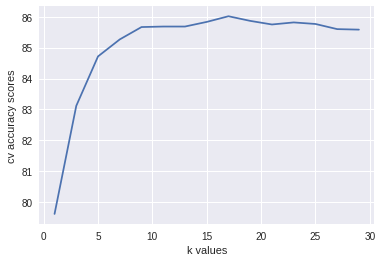

In [24]:
from sklearn.neighbors import KNeighborsClassifier
cv_scores =[]
k_values = []
for i in range(1,30,2):
    # instantiate learning model (k = 30)
    knn = KNeighborsClassifier(n_neighbors=i)

    # fitting the model on crossvalidation train
    knn.fit(X_tr_vector, y_tr)

    # predict the response on the crossvalidation train
    pred = knn.predict(X_cv_vector)

    # evaluate CV accuracy
    acc = accuracy_score(y_cv, pred, normalize=True) * float(100)
    cv_scores.append(acc)
    k_values.append(i)
plt.plot(k_values, cv_scores)
plt.xlabel('k values')
plt.ylabel('cv accuracy scores')
plt.show()

# Finding Optimal K


The optimal number of neighbors is 17.


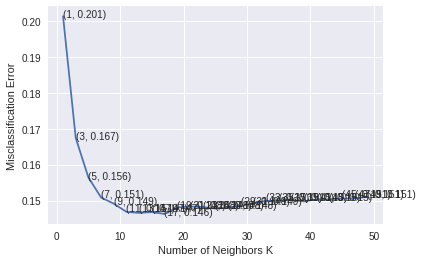

the misclassification error for each k value is :  [0.201 0.167 0.156 0.151 0.149 0.147 0.147 0.147 0.146 0.148 0.148 0.148
 0.148 0.148 0.149 0.149 0.15  0.15  0.15  0.15  0.15  0.15  0.151 0.151
 0.151]


In [25]:
# creating odd list of K for KNN
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_tr_vector, y_tr, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

# plot misclassification error vs k 
plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,3))

# CV Accuracy using Optimal K

In [26]:

# ============================== KNN with k = optimal_k  and algorithm =auto ===============================================
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k,algorithm='auto')

# fitting the model
knn_optimal.fit(X_tr_vector, y_tr)

# predict the response
pred = knn_optimal.predict(X_cv_vector)

# evaluate accuracy
acc = accuracy_score(y_cv, pred) * 100
print('\nThe CV accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))


The CV accuracy of the knn classifier for k = 17 is 86.016667%


# Train & Test Accuarcy Using Optimal K

In [27]:

# ============================== KNN with k = optimal_k  and algorithm =auto ===============================================
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k,algorithm='auto')

# fitting the model
knn_optimal.fit(X_tr_vector, y_tr)

# predict the response
pred = knn_optimal.predict(X_test_vector)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe Test accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))
trainacc = knn_optimal.score(X_tr_vector, y_tr)*100
print('\nThe Train accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, trainacc))


The Test accuracy of the knn classifier for k = 17 is 84.720000%

The Train accuracy of the knn classifier for k = 17 is 86.092857%


# Conclusion

In [29]:
from prettytable import PrettyTable
t = PrettyTable()
t.field_names = ['Model', 'Hyperparameter','CV Error','Train Error','Test Error']
t.add_row(["KNeighborsClassifier using tfidfW2Vec vectorizer","17","0.13983333","0.13907143","0.1528"])
print(t)

+--------------------------------------------------+----------------+------------+-------------+------------+
|                      Model                       | Hyperparameter |  CV Error  | Train Error | Test Error |
+--------------------------------------------------+----------------+------------+-------------+------------+
| KNeighborsClassifier using tfidfW2Vec vectorizer |       17       | 0.13983333 |  0.13907143 |   0.1528   |
+--------------------------------------------------+----------------+------------+-------------+------------+
